In [1]:
from stations.models import Measurement, Prediction, Station
from asgiref.sync import sync_to_async
import pandas as pd
import matplotlib
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
#import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model, model_from_json
import pickle
import glob

from geolomasexp.configuration import LSTMTrainingScriptConfig

from geolomasexp.data import read_time_series_from_csv
from geolomasexp.feature import (
    get_dataset_from_series,
    get_interest_variable
)
from geolomasexp.model_hyperopt import (
    get_lstm_nnet_opt
)
from geolomasexp.model import (train_val_test_split)


import ipdb



Using TensorFlow backend.
/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(

In [9]:
def read_time_series_from_db(
            sensor='A620',
            date_col='date',
            hr_col='hr',
            min_col='minute',
            numeric_var='temperature',
            sensor_var='inme',  # TODO : change this for station_code in all the script
            date_since=None,
            which_minutes = [0,15,30,45]
            ):
        # get the station (sensor)
        #station = Station.objects.get(code=sensor)
        # get all the measurements from this station
        measurements = Measurement.objects.filter(station=Station.objects.get(
            code=sensor).id)
        if date_since is not None:
            measurements = measurements.filter(datetime__gte=date_since)

        print(
            'Measurements to read from database for sensor {} with query \n{}'.
            format(sensor, measurements.query))
        # get a dataframe from the measurements
        dataset = pd.DataFrame(
            list(measurements.values('datetime', 'attributes')))
        print('Dataset from database of shape {}'.format(
            dataset.shape))
        # parse datetime column to get sepearae date, hr and minute columns
        dataset[date_col] = dataset.datetime.dt.date
        dataset[hr_col] = dataset.datetime.dt.hour
        dataset[min_col] = dataset.datetime.dt.minute
        # get the numeric var column parsing the json
        dataset[numeric_var] = dataset.attributes.apply(
            lambda x: x[numeric_var])
        dataset[sensor_var] = sensor

        # sort and re-index before returning
        dataset.sort_values([date_col, hr_col,min_col], inplace=True, ascending=True)
        dataset.reset_index(inplace=True)

        return dataset.loc[dataset.minute.isin(which_minutes)]

In [12]:
dataframe = read_time_series_from_db(which_minutes=range(60))
dataframe

Measurements to read from database for sensor A620 with query 
SELECT "stations_measurement"."id", "stations_measurement"."datetime", "stations_measurement"."station_id", "stations_measurement"."attributes" FROM "stations_measurement" WHERE "stations_measurement"."station_id" = 2
Dataset from database of shape (201600, 2)


,index,datetime,attributes,date,hr,minute,temperature,inme
0,0,2011-01-01 00:00:00+00:00,"{'pm25': 0.0, 'humidity': 0.0, 'pressure': 0.0...",2011-01-01,0,0,0.0,A620
1,120,2011-01-01 00:15:00+00:00,"{'pm25': -0.3, 'humidity': -0.3, 'pressure': -...",2011-01-01,0,15,-0.3,A620
2,121,2011-01-01 00:30:00+00:00,"{'pm25': 0.6, 'humidity': 0.6, 'pressure': 0.6...",2011-01-01,0,30,0.6,A620
3,122,2011-01-01 00:45:00+00:00,"{'pm25': -0.9, 'humidity': -0.9, 'pressure': -...",2011-01-01,0,45,-0.9,A620
4,1,2011-01-01 01:00:00+00:00,"{'pm25': 0.0, 'humidity': 0.0, 'pressure': 0.0...",2011-01-01,1,0,0.0,A620
...,...,...,...,...,...,...,...,...
201595,201596,2016-09-30 22:45:00+00:00,"{'pm25': -0.9, 'humidity': 89.1, 'pressure': 1...",2016-09-30,22,45,18.5,A620
201596,201455,2016-09-30 23:00:00+00:00,"{'pm25': 0.4, 'humidity': 90.0, 'pressure': 10...",2016-09-30,23,0,19.1,A620
201597,201597,2016-09-30 23:15:00+00:00,"{'pm25': 0.10000000000000003, 'humidity': 89.7...",2016-09-30,23,15,18.8,A620
201598,201598,2016-09-30 23:30:00+00:00,"{'pm25': 1.0, 'humidity': 90.6, 'pressure': 10...",2016-09-30,23,30,19.7,A620


In [34]:
def get_database_data(djmodel = Prediction,sensor = 'A620',numeric_vars = ['temperature'],last_n_steps = -1):
    stat_id = Station.objects.get(code=sensor).id
    if last_n_steps > 0:
        records = djmodel.objects.filter(station=stat_id).order_by('-datetime')[:last_n_steps]
    else :
        records = djmodel.objects.filter(station=stat_id)
    dataset = pd.DataFrame(list(records.values('datetime', 'attributes')))
    dataset['date'] = dataset.datetime.dt.date
    dataset['hr'] = dataset.datetime.dt.hour
    dataset['minute'] = dataset.datetime.dt.minute
    # get the numeric var column parsing the json
    for numeric_var in numeric_vars:
        dataset[numeric_var] = dataset.attributes.apply(lambda x: x[numeric_var])
    # sort and re-index before returning
    dataset.sort_values(['date', 'hr','minute'], inplace=True, ascending=True)
    dataset.reset_index(inplace=True)
    return dataset

predictions_df = get_database_data(numeric_vars = ['temperature','humidity'])
predictions_df.sort_values('datetime',ascending = True,inplace = True)
predictions_df.set_index('datetime',inplace=True)
predictions_df

,index,attributes,date,hr,minute,temperature,humidity
datetime,,,,,,,
2016-09-30 23:15:00+00:00,60,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-09-30,23,15,36.621910,0.000000
2016-09-30 23:30:00+00:00,0,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-09-30,23,30,36.621983,0.000000
2016-09-30 23:45:00+00:00,1,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-09-30,23,45,36.622902,0.000000
2016-10-01 00:00:00+00:00,28,"{'pm25': 0, 'humidity': 99.06092071533203, 'pr...",2016-10-01,0,0,82.913536,99.060921
2016-10-01 00:15:00+00:00,29,"{'pm25': 0, 'humidity': 99.06130981445312, 'pr...",2016-10-01,0,15,82.967300,99.061310
...,...,...,...,...,...,...,...
2016-10-03 22:45:00+00:00,286,"{'pm25': 0, 'humidity': 99.0616226196289, 'pre...",2016-10-03,22,45,83.153732,99.061623
2016-10-03 23:00:00+00:00,287,"{'pm25': 0, 'humidity': 99.0616226196289, 'pre...",2016-10-03,23,0,83.153748,99.061623
2016-10-03 23:15:00+00:00,288,"{'pm25': 0, 'humidity': 99.0616226196289, 'pre...",2016-10-03,23,15,83.153732,99.061623


In [33]:
measurement_df = get_database_data(Measurement,numeric_vars = ['temperature','humidity'],last_n_steps=30)
measurement_df.sort_values('datetime',ascending = True,inplace = True)
measurement_df.set_index('datetime',inplace=True)
measurement_df

,index,attributes,date,hr,minute,temperature,humidity
datetime,,,,,,,
2016-09-30 16:30:00+00:00,29,"{'pm25': 0.6, 'humidity': 85.6, 'pressure': 10...",2016-09-30,16,30,21.1,85.6
2016-09-30 16:45:00+00:00,28,"{'pm25': -0.9, 'humidity': 84.1, 'pressure': 1...",2016-09-30,16,45,19.6,84.1
2016-09-30 17:00:00+00:00,27,"{'pm25': 0.0, 'humidity': 78.0, 'pressure': 10...",2016-09-30,17,0,21.1,78.0
2016-09-30 17:15:00+00:00,26,"{'pm25': -0.3, 'humidity': 77.7, 'pressure': 1...",2016-09-30,17,15,20.8,77.7
2016-09-30 17:30:00+00:00,25,"{'pm25': 0.6, 'humidity': 78.6, 'pressure': 10...",2016-09-30,17,30,21.7,78.6
2016-09-30 17:45:00+00:00,24,"{'pm25': -0.9, 'humidity': 77.1, 'pressure': 1...",2016-09-30,17,45,20.2,77.1
2016-09-30 18:00:00+00:00,23,"{'pm25': 0.0, 'humidity': 75.0, 'pressure': 10...",2016-09-30,18,0,21.5,75.0
2016-09-30 18:15:00+00:00,22,"{'pm25': -0.3, 'humidity': 74.7, 'pressure': 1...",2016-09-30,18,15,21.2,74.7
2016-09-30 18:30:00+00:00,21,"{'pm25': 0.6, 'humidity': 75.6, 'pressure': 10...",2016-09-30,18,30,22.1,75.6


In [20]:
plot_df = pd.concat([predictions_df[['datetime','temperature']],measurement_df[['datetime','temperature']]])
plot_df.sort_values('datetime',ascending = True,inplace= True)
plot_df.set_index('datetime',inplace=True)

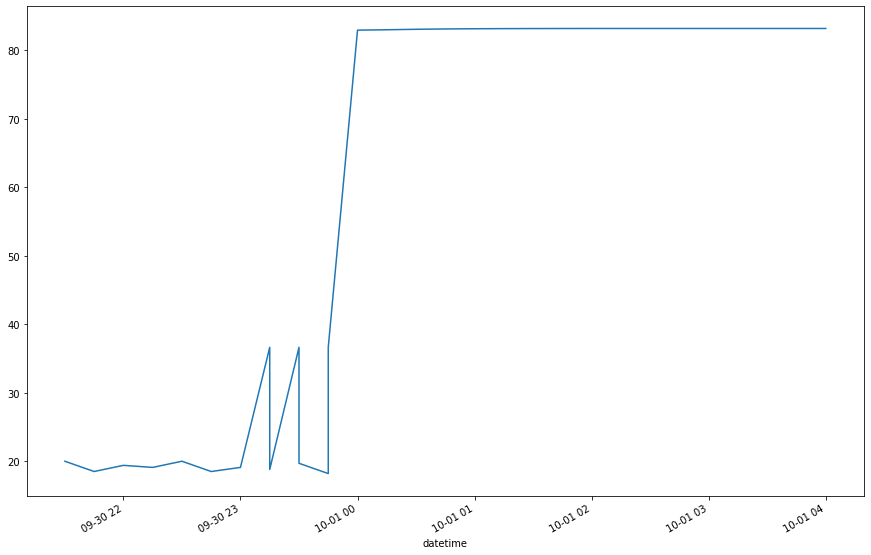

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,10))
plot_df.temperature[:30].plot()

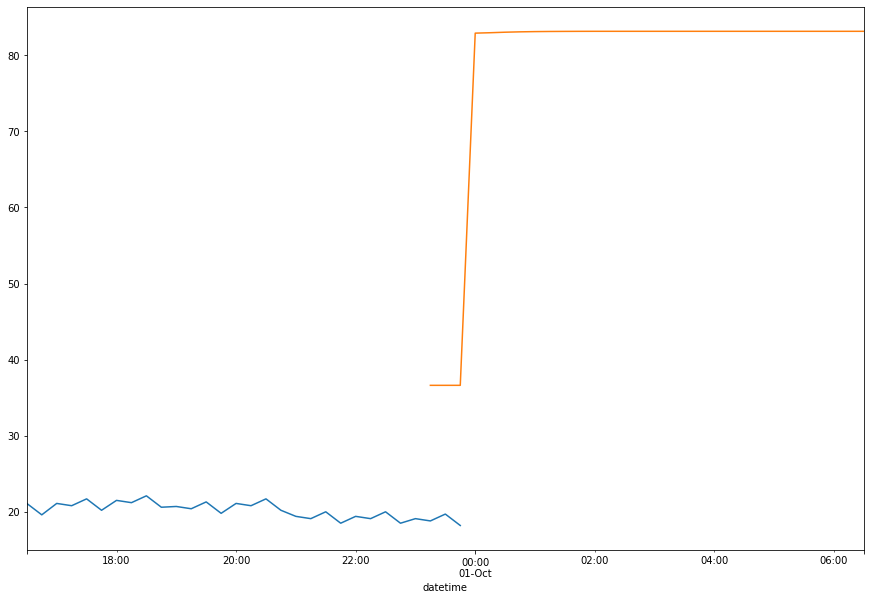

In [37]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,10))
measurement_df.temperature.plot()
predictions_df.temperature[:30].plot()
plt.show()

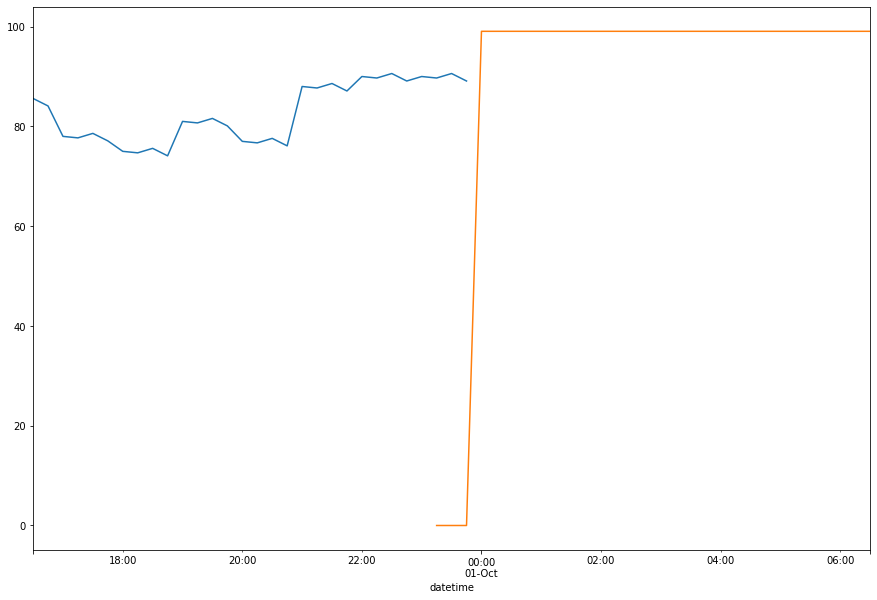

In [38]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,10))
measurement_df.humidity.plot()
predictions_df.humidity[:30].plot()
plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,10))
measurement_df.sort_values('datetime',ascending = True).set_index('datetime').temperature.plot()
predictions_df.sort_values('datetime',ascending = True).set_index('datetime').temperature[:20].plot()
plt.show()

In [45]:

out_model_name = glob.glob('../models/*_hyperopt_model_*.hdf5')[-1]
out_model_name = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_hyperopt_model_2020-04-20_23:16:42.hdf5'
print(out_model_name)
#out_model_name = '../models/esp:10_eps:2_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[1, 2, 3][2, 3][0.1, 0.8]3_hyperopt_model_2020-02-25_10:13:29.hdf5'
model_hyper = load_model(out_model_name)
print(model_hyper.summary())


../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_hyperopt_model_2020-04-20_23:16:42.hdf5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8, 16)             1152      
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8, 16)             2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_7 (LS

In [67]:
model_pckg_filename = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-20_23:16:42.model'
with open(model_pckg_filename, 'rb') as file_pi:
    model_package = pickle.load(file_pi)
    
model = model_package['model']
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8, 16)             1152      
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8, 16)             2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 8, 16)             2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)               

In [64]:
import numpy as np
scaler = model_package['scaler']
datapoint = measurement_df.temperature.values[:8]
print(datapoint)
for step in range(10) :
    X = np.array(datapoint[-8:]).reshape(1,model.input_shape[1],model.input_shape[2])
    y = scaler.inverse_transform(model.predict(X))
    datapoint = np.append(datapoint,y)
print(datapoint)

[21.1 19.6 21.1 20.8 21.7 20.2 21.5 21.2]
[21.1        19.6        21.1        20.8        21.7        20.2
 21.5        21.2        82.95090485 82.99260712 83.05224609 83.0941925
 83.12081146 83.13577271 83.14514923 83.15190887 83.15369415 83.15371704]


In [66]:
measurement_df.temperature.values[:8+10]

array([21.1, 19.6, 21.1, 20.8, 21.7, 20.2, 21.5, 21.2, 22.1, 20.6, 20.7,
       20.4, 21.3, 19.8, 21.1, 20.8, 21.7, 20.2])